In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 50)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from google.cloud import bigquery
from google.oauth2 import service_account
from pathlib import Path
from sklearn import set_config; set_config(display='diagram')
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config; set_config(display='diagram')
from sklearn.preprocessing import FunctionTransformer
from flaml import AutoML



In [2]:
df = pd.read_csv('../data/clean_data.csv')
df

,TRAIN_SERVICE_CODE_AFFECTED,SERVICE_GROUP_CODE_AFFECTED,ENGLISH_DAY_TYPE,APP_TIMETABLE_FLAG_AFF,UNIT_CLASS_AFFECTED,INCIDENT_REASON,PERFORMANCE_EVENT_CODE,PFPI_MINUTES,Lat_OR,Lon_OR,Lat_DES,Lon_DES,ORIG_MONTH_SIN,ORIG_MONTH_COS,ORIG_DAY_SIN,ORIG_DAY_COS,ORIG_HOUR_SIN,ORIG_HOUR_COS,ORIG_MINUTE_SIN,ORIG_MINUTE_COS,DEST_MONTH_SIN,DEST_MONTH_COS,DEST_DAY_SIN,DEST_DAY_COS,DEST_HOUR_SIN,DEST_HOUR_COS,DEST_MINUTE_SIN,DEST_MINUTE_COS
0,22214000,EK01,SA,Y,375.0,MD,M,9.0,51.54343,-0.02447,51.54343,-0.02447,0.951057,0.309017,7.431448e-01,0.669131,0.913545,4.067366e-01,-1.000000,-1.836970e-16,0.951057,0.309017,7.431448e-01,0.669131,0.951057,0.309017,-0.978148,0.207912
1,22214000,EK01,WD,Y,378.0,MD,M,12.0,51.54343,-0.02447,51.54343,-0.02447,0.951057,0.309017,9.135455e-01,-0.406737,0.809017,5.877853e-01,-0.587785,-8.090170e-01,0.951057,0.309017,9.135455e-01,-0.406737,0.866025,0.500000,-0.809017,-0.587785
2,22214000,EK01,WD,Y,378.0,X8,M,8.0,51.54343,-0.02447,51.54343,-0.02447,0.104528,0.994522,5.665539e-16,-1.000000,0.866025,-5.000000e-01,0.978148,-2.079117e-01,0.104528,0.994522,5.665539e-16,-1.000000,0.809017,-0.587785,0.913545,-0.406737
3,22214000,EK01,SA,Y,375.0,TG,M,10.0,51.54343,-0.02447,51.54343,-0.02447,0.913545,0.406737,5.877853e-01,-0.809017,0.951057,-3.090170e-01,-0.309017,-9.510565e-01,0.913545,0.406737,5.877853e-01,-0.809017,0.913545,-0.406737,-0.207912,-0.978148
4,22214000,EK01,SA,Y,375.0,TG,M,11.0,51.54343,-0.02447,51.54343,-0.02447,0.913545,0.406737,5.877853e-01,-0.809017,0.951057,-3.090170e-01,-0.669131,7.431448e-01,0.913545,0.406737,5.877853e-01,-0.809017,0.913545,-0.406737,-0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493246,21921000,EK01,WD,Y,710.0,XL,M,4.0,51.54014,0.07965,51.51911,0.11477,0.104528,0.994522,6.691306e-01,-0.743145,0.743145,-6.691306e-01,0.104528,-9.945219e-01,0.104528,0.994522,6.691306e-01,-0.743145,0.669131,-0.743145,0.669131,0.743145
493247,21921000,EK01,WD,Y,710.0,T3,M,12.0,51.54014,0.07965,51.51911,0.11477,0.309017,0.951057,9.781476e-01,0.207912,0.500000,8.660254e-01,-0.866025,-5.000000e-01,0.309017,0.951057,9.781476e-01,0.207912,0.500000,0.866025,-0.913545,0.406737
493248,21921000,EK01,WD,Y,710.0,M1,M,18.0,51.54014,0.07965,51.51911,0.11477,0.500000,0.866025,8.090170e-01,0.587785,1.000000,2.832769e-16,0.587785,-8.090170e-01,0.500000,0.866025,8.090170e-01,0.587785,0.994522,-0.104528,0.207912,0.978148
493249,21921000,EK01,WD,Y,710.0,FX,M,1.5,51.54014,0.07965,51.51911,0.11477,0.104528,0.994522,5.665539e-16,-1.000000,0.978148,2.079117e-01,0.809017,5.877853e-01,0.104528,0.994522,5.665539e-16,-1.000000,0.978148,0.207912,-0.978148,0.207912


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493251 entries, 0 to 493250
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TRAIN_SERVICE_CODE_AFFECTED  493251 non-null  int64  
 1   SERVICE_GROUP_CODE_AFFECTED  493251 non-null  object 
 2   ENGLISH_DAY_TYPE             493251 non-null  object 
 3   APP_TIMETABLE_FLAG_AFF       493251 non-null  object 
 4   UNIT_CLASS_AFFECTED          493251 non-null  float64
 5   INCIDENT_REASON              493251 non-null  object 
 6   PERFORMANCE_EVENT_CODE       493251 non-null  object 
 7   PFPI_MINUTES                 493251 non-null  float64
 8   Lat_OR                       493251 non-null  float64
 9   Lon_OR                       493251 non-null  float64
 10  Lat_DES                      493251 non-null  float64
 11  Lon_DES                      493251 non-null  float64
 12  ORIG_MONTH_SIN               493251 non-null  float64
 13 

In [4]:
num_transformer = MinMaxScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary')



def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['Lat_OR', 'Lon_OR', 'Lat_DES', 'Lon_DES']),
    ('cat_transformer', cat_transformer, ['ENGLISH_DAY_TYPE', 'SERVICE_GROUP_CODE_AFFECTED', 'INCIDENT_REASON',
                                                        'UNIT_CLASS_AFFECTED', 'TRAIN_SERVICE_CODE_AFFECTED', 
                                                     'PERFORMANCE_EVENT_CODE', 
                                                     'APP_TIMETABLE_FLAG_AFF']),
    ('month_sin', sin_transformer(12), ['ORIG_MONTH', 'DEST_MONTH']),
    ('month_cos', cos_transformer(12), ['ORIG_MONTH', 'DEST_MONTH']),
    ('day_sin', sin_transformer(31), ['ORIG_DAY', 'DEST_DAY']),
    ('day_cos', cos_transformer(31), ['ORIG_DAY', 'DEST_DAY']),
    ('hour_sin', sin_transformer(24), ['ORIG_HOUR', 'DEST_HOUR']),
    ('hour_cos', cos_transformer(24), ['ORIG_HOUR', 'DEST_HOUR']),
    ('minute_sin', sin_transformer(60), ['ORIG_MINUTE', 'DSET_MINUTE']),
    ('minute_cos', cos_transformer(60), ['ORIG_MINUTE', 'DEST_MINUTE'])
], sparse_threshold=0, remainder='drop')

In [5]:
num_transformer = MinMaxScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse = False)

transformer = make_column_transformer((num_transformer, ['Lat_OR','Lon_OR', 'Lat_DES','Lon_DES']),
                                  (cat_transformer, ['ENGLISH_DAY_TYPE', 'SERVICE_GROUP_CODE_AFFECTED', 'INCIDENT_REASON',
                                                        'UNIT_CLASS_AFFECTED', 'TRAIN_SERVICE_CODE_AFFECTED', 
                                                     'PERFORMANCE_EVENT_CODE', 
                                                     'APP_TIMETABLE_FLAG_AFF']),
                                remainder = 'passthrough')


pipe = Pipeline([('transformer', transformer)])

pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Lat_OR', 'Lon_OR',
                                                   'Lat_DES', 'Lon_DES']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['ENGLISH_DAY_TYPE',
                                                   'SERVICE_GROUP_CODE_AFFECTED',
                                                   'INCIDENT_REASON',
                                                   'UNIT_CLASS_AFFECTED',
                                                   'TRAIN_SERVICE_CODE_AFFECTED',
                                                   'PERFORMANCE_EVENT_CODE',
                                                   'APP_TIMETABLE_FLAG_AFF'])]))])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PFPI_MINUTES'), df['PFPI_MINUTES'], test_size=0.2)

In [7]:
X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.transform(X_test)


In [8]:
X_train_scaled[0]

array([ 6.08845755e-01,  3.89787538e-01,  5.66381526e-01,  3.99768725e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model_lin = LinearRegression()

cross_val_score(model_lin, X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean()

-3313338034.5396614

In [15]:
model_lin.fit(X_train_scaled, y_train)
model_lin.score(X_test_scaled, y_test)

-1.0760879670146056e+16

In [18]:
model_xgb = XGBRegressor(max_depth=10, n_estimators=500, learning_rate=0.01, n_jobs = -1)
cross_val_score(model_xgb, X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean()

-4.217196101654763

In [19]:
model_xgb.fit(X_train_scaled, y_train)
model_xgb.score(X_test_scaled, y_test)

0.301517791919063

In [9]:
automl = AutoML()
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
    "task": 'regression',  # task type
    "log_file_name": 'train_delays.log',  # flaml log file
    "seed": 7654321,  # random seed
}
automl.fit(X_train=X_train_scaled, y_train=y_train, **settings)


[flaml.automl.logger: 12-05 09:31:20] {1679} INFO - task = regression
[flaml.automl.logger: 12-05 09:31:20] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-05 09:31:22] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-05 09:31:22] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-05 09:31:22] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-05 09:31:22] {2344} INFO - Estimated sufficient time budget=95444s. Estimated necessary time budget=95s.
[flaml.automl.logger: 12-05 09:31:22] {2391} INFO -  at 2.4s,	estimator xgboost's best error=30.6360,	best estimator xgboost's best error=30.6360
[flaml.automl.logger: 12-05 09:31:22] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-05 09:31:22] {2391} INFO -  at 2.5s,	estimator xgboost's best error=30.6360,	best estimator xgboost's best error=30.6360
[flaml.automl.logger: 12-05 09:31:22] {2218} INFO - iteration 2, curren

[flaml.automl.logger: 12-05 09:35:47] {2218} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 12-05 09:36:13] {2391} INFO -  at 293.5s,	estimator xgboost's best error=18.4221,	best estimator xgboost's best error=18.4221
[flaml.automl.logger: 12-05 09:36:13] {2218} INFO - iteration 34, current learner xgboost
[flaml.automl.logger: 12-05 09:36:29] {2391} INFO -  at 309.2s,	estimator xgboost's best error=18.2538,	best estimator xgboost's best error=18.2538
[flaml.automl.logger: 12-05 09:36:29] {2218} INFO - iteration 35, current learner xgboost
[flaml.automl.logger: 12-05 09:36:47] {2391} INFO -  at 327.8s,	estimator xgboost's best error=18.2538,	best estimator xgboost's best error=18.2538
[flaml.automl.logger: 12-05 09:36:47] {2218} INFO - iteration 36, current learner xgboost
[flaml.automl.logger: 12-05 09:36:54] {2391} INFO -  at 334.0s,	estimator xgboost's best error=18.2538,	best estimator xgboost's best error=18.2538
[flaml.automl.logger: 12-05 09:36:54] {2218} INF

<AxesSubplot:ylabel='Frequency'>

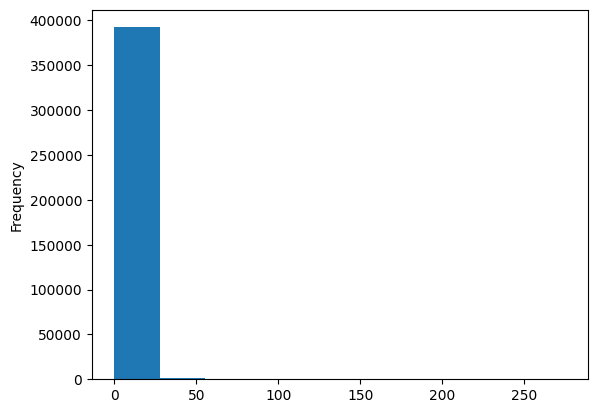

In [11]:
y_train.plot(kind='hist')

In [12]:
from sklearn.preprocessing import LabelEncoder
